This is a modified version of the Pix2Pix GAN model tensorflow notebook from the link below

## https://www.tensorflow.org/tutorials/generative/pix2pix

## Import TensorFlow and other libraries

In [1]:
import os
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
import tensorflow as tf


import time

from matplotlib import pyplot as plt
from IPython import display
import numpy as np
import os
import sys
import cv2
from sklearn.model_selection import train_test_split
import tkinter
from tkinter import filedialog

tkinter.Tk().withdraw()

path=filedialog.askdirectory(title='path for whole dataset')

#The following inputs along with the time of training help differentiate the pre-trained weights
date="Oct15_Same"
mask="Dataset1"

from glob import glob


2022-11-03 11:40:46.688282: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [4]:
BUFFER_SIZE = 400
BATCH_SIZE = 350 #25 20
IMAGE_SIZE=256

In [5]:
def load_data(path, split=0.02):
    images = sorted(glob(os.path.join(path, "Images/*")))
    masks = sorted(glob(os.path.join(path, "Masks/*")))

    total_size = len(images)
    valid_size = int(split * total_size)
    test_size = int(split * total_size)

    train_x, valid_x = train_test_split(images, test_size=valid_size, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=valid_size, random_state=42)

    train_x, test_x = train_test_split(train_x, test_size=test_size, random_state=42)
    train_y, test_y = train_test_split(train_y, test_size=test_size, random_state=42)

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

In [6]:
(train_x, train_y), (valid_x, valid_y), (test_x, test_y)=load_data(path)

In [7]:
len(train_y)

9249

In [53]:
# Training dataset input function is separated from testing and validation to include future data augmentation approaches
def load_train(a,b=0,condtn=True):
    image1 = tf.io.read_file(a)
    
    input_image = tf.image.decode_png(image1)
   
    input_image=tf.image.resize(input_image, [256, 256],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    input_image=tf.cast(input_image,tf.float32)
    
    
    
    if(condtn==True):  # Same Function can be used for H&E images only
        image2 = tf.io.read_file(b)
        real_image = tf.image.decode_png(image2)
    
        real_image=tf.image.resize(real_image, [256, 256],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    
        real_image=tf.cast(real_image,tf.float32)
       
        real_image = (real_image / 127.5) - 1
        input_image = (input_image / 127.5) - 1
        return input_image, real_image
    else:
        input_image = (input_image / 127.5) - 1
        return input_image

In [9]:
def load_test(a,b=0,condtn=True): 
    image1 = tf.io.read_file(a)
    input_image = tf.image.decode_png(image1,channels=3)
    
    input_image=tf.image.resize(input_image, [256, 256],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    input_image=tf.cast(input_image,tf.float32)
    
    input_image = (input_image / 127.5) - 1
    
    if(condtn==True): # Same Function can be used for H&E images only
        image2 = tf.io.read_file(b)
        real_image = tf.image.decode_png(image2)
        

        real_image=tf.image.resize(real_image, [256, 256],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    
        real_image=tf.cast(real_image,tf.float32)
    
        real_image = (real_image / 127.5) - 1

        return input_image, real_image
    else:
        return input_image

In [62]:
def load_valid(a,b=0,condtn=True):
    image1 = tf.io.read_file(a)
    input_image = tf.image.decode_png(image1,channels=3)
    
    if(input_image.shape!=([256,256,3])):
        print(input_image.shape)
        print(256-input_image.shape[0])
        print(256-input_image.shape[1])
        input_image=tf.image.pad_to_bounding_box(input_image,0,0,256,256)

    input_image=tf.cast(input_image,tf.float32)
    
    input_image = (input_image / 127.5) - 1
    
    if(condtn==True):
        image2 = tf.io.read_file(b)
        real_image = tf.image.decode_png(image2)

 
    
        real_image = (real_image / 127.5) - 1

        return input_image, real_image
    else:
        return input_image

In [12]:
train_dataset=tf.data.Dataset.from_tensor_slices((train_x,train_y))
train_dataset=train_dataset.shuffle(BUFFER_SIZE)
train_dataset=train_dataset.map(load_train)
train_dataset=train_dataset.batch(BATCH_SIZE)

valid_dataset=tf.data.Dataset.from_tensor_slices((valid_x,valid_y))
valid_dataset=valid_dataset.map(load_test)
valid_dataset=valid_dataset.batch(1)

test_dataset=tf.data.Dataset.from_tensor_slices((test_x,test_y))
test_dataset=test_dataset.map(load_test)
test_dataset=test_dataset.batch(1)

2022-11-03 11:41:01.976757: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-03 11:41:02.003825: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3700145000 Hz
2022-11-03 11:41:02.004450: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55a29b7fa400 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-11-03 11:41:02.004461: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-11-03 11:41:02.005397: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:0d:00.0 name: Quadro RTX 8000 computeCapability: 7.5
coreClock: 1.77G

## Build the Generator
  * The architecture of generator is a modified U-Net.
  * Each block in the encoder is (Conv -> Batchnorm -> Leaky ReLU)
  * Each block in the decoder is (Transposed Conv -> Batchnorm -> Dropout(applied to the first 3 blocks) -> ReLU)
  * There are skip connections between the encoder and decoder (as in U-Net).


In [15]:
OUTPUT_CHANNELS = 3

In [16]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [17]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(inp, 0))
print (down_result.shape)

2022-11-03 11:41:04.574486: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


(1, 128, 128, 3)


2022-11-03 11:41:05.153848: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


In [18]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [19]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 256, 256, 3)


In [20]:
def Generator():
  size=4
  inputs = tf.keras.layers.Input(shape=[256,256,3])

  down_stack = [
    downsample(64, size, apply_batchnorm=False), # (bs, 128, 128, 64)
    downsample(128,size), # (bs, 64, 64, 128)
    downsample(256, size), # (bs, 32, 32, 256)
    downsample(512, size), # (bs, 16, 16, 512)
    downsample(512, size), # (bs, 8, 8, 512)
    downsample(512, size), # (bs, 4, 4, 512)
    downsample(512, size), # (bs, 2, 2, 512)
    downsample(512, size), # (bs, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, size, apply_dropout=True), # (bs, 2, 2, 1024)
    upsample(512, size, apply_dropout=True), # (bs, 4, 4, 1024)
    upsample(512, size, apply_dropout=True), # (bs, 8, 8, 1024)
    upsample(512, size), # (bs, 16, 16, 1024)
    upsample(256, size), # (bs, 32, 32, 512)
    upsample(128, size), # (bs, 64, 64, 256)
    upsample(64, size), # (bs, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, size,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh') # (bs, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [21]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


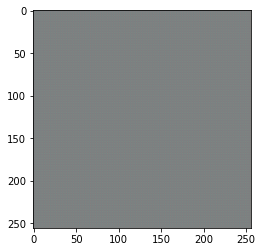

In [22]:
gen_output = generator(inp[tf.newaxis,...],training=False)
plt.imshow(gen_output[0,...]*0.5+0.5)

* **Generator loss**
  * It is a sigmoid cross entropy loss of the generated images and an **array of ones**.
  * The [paper](https://arxiv.org/abs/1611.07004) also includes L1 loss which is MAE (mean absolute error) between the generated image and the target image.
  * This allows the generated image to become structurally similar to the target image.
  * The formula to calculate the total generator loss = gan_loss + LAMBDA * l1_loss, where LAMBDA = 100. This value was decided by the authors of the [paper](https://arxiv.org/abs/1611.07004).

The training procedure for the generator is shown below:

In [23]:
LAMBDA = 100

In [24]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
  #LAMBDA=dynamic_lambda(target,gen_output)

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

![Generator Update Image](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/gen.png?raw=1)


## Build the Discriminator
  * The Discriminator is a PatchGAN.
  * Each block in the discriminator is (Conv -> BatchNorm -> Leaky ReLU)
  * The shape of the output after the last layer is (batch_size, 30, 30, 1)
  * Each 30x30 patch of the output classifies a 70x70 portion of the input image (such an architecture is called a PatchGAN).
  * Discriminator receives 2 inputs.
    * Input image and the target image, which it should classify as real.
    * Input image and the generated image (output of generator), which it should classify as fake.
    * We concatenate these 2 inputs together in the code (`tf.concat([inp, tar], axis=-1)`)

In [25]:
def Discriminator():
  size=4
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar]) # (bs, 256, 256, channels*2)

  down1 = downsample(64, size, False)(x) # (bs, 128, 128, 64)
  down2 = downsample(128, size)(down1) # (bs, 64, 64, 128)
  down3 = downsample(256, size)(down2) # (bs, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, size, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, size, strides=1,
                                kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

In [26]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


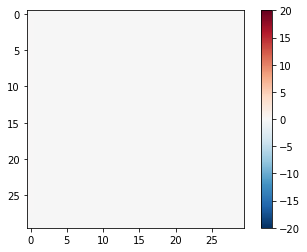

In [27]:
disc_out = discriminator([inp[tf.newaxis,...], gen_output], training=False)
plt.imshow(disc_out[0,...,-1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

**Discriminator loss**
  * The discriminator loss function takes 2 inputs; **real images, generated images**
  * real_loss is a sigmoid cross entropy loss of the **real images** and an **array of ones(since these are the real images)**
  * generated_loss is a sigmoid cross entropy loss of the **generated images** and an **array of zeros(since these are the fake images)**
  * Then the total_loss is the sum of real_loss and the generated_loss


In [28]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [31]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

    total_disc_loss = real_loss + generated_loss
    #print(total_disc_loss)
    return total_disc_loss

The training procedure for the discriminator is shown below.

To learn more about the architecture and the hyperparameters you can refer the [paper](https://arxiv.org/abs/1611.07004).

![Discriminator Update Image](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/dis.png?raw=1)


## Define the Optimizers and Checkpoint-saver


In [32]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [33]:
checkpoint_dir = './training_checkpoints/'+date+"/"+mask
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)
manager = tf.train.CheckpointManager(
    checkpoint, directory=checkpoint_prefix, max_to_keep=5)

## Generate Images

Write a function to plot some images during training.

* We pass images from the test dataset to the generator.
* The generator will then translate the input image into the output.
* Last step is to plot the predictions and **voila!**

Note: The `training=True` is intentional here since
we want the batch statistics while running the model
on the test dataset. If we use training=False, we will get
the accumulated statistics learned from the training dataset
(which we don't want)

In [35]:
def generate_images(model, test_input, tar):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15,15))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ref for style_transfer', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

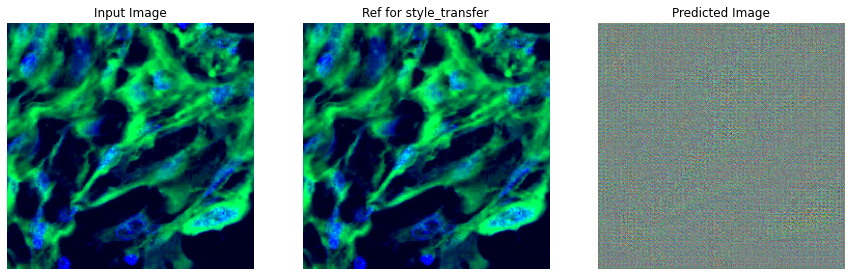

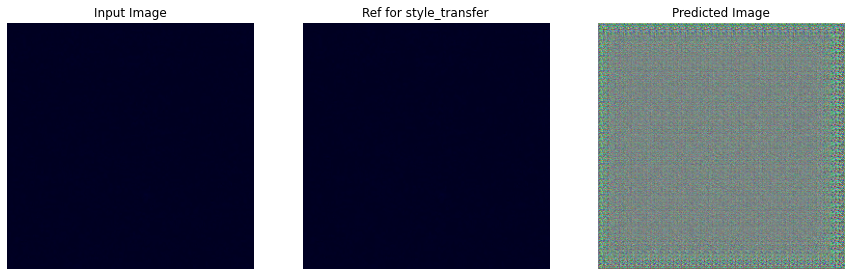

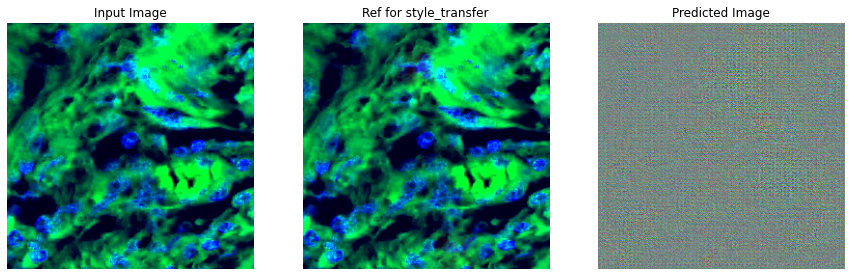

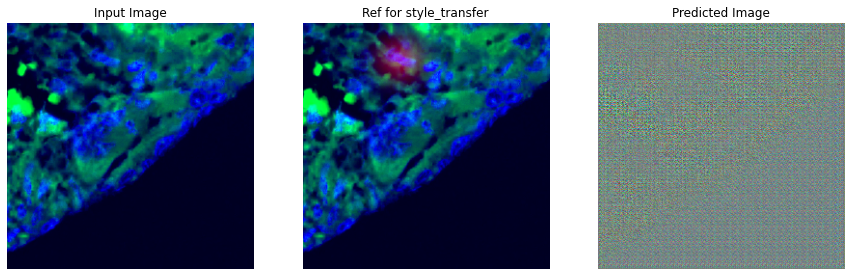

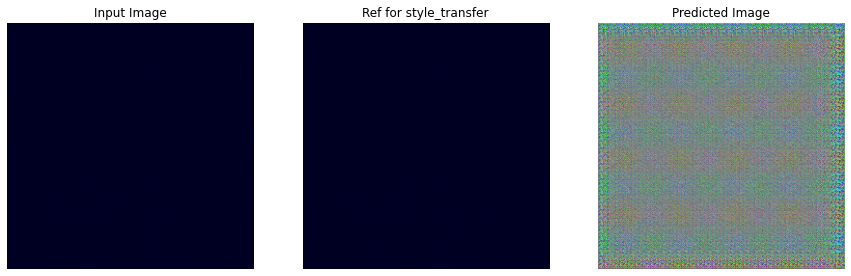

In [36]:
for example_input, example_target in test_dataset.take(5):
    #print("*")
    generate_images(generator, example_input, example_target)

## Training

* For each example input generate an output.
* The discriminator receives the input_image and the generated image as the first input. The second input is the input_image and the target_image.
* Next, we calculate the generator and the discriminator loss.
* Then, we calculate the gradients of loss with respect to both the generator and the discriminator variables(inputs) and apply those to the optimizer.
* Then log the losses to TensorBoard.

In [37]:
EPOCHS = 150

In [38]:
# Saving Directories with different dates
import datetime
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [40]:
@tf.function
def train_step(input_image, target, epoch):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)
    
    ps=tf.reduce_mean(tf.image.psnr(gen_output,target, max_val=1.0))

    ss=tf.reduce_mean(tf.image.ssim(gen_output,target, 1.0))

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))
  
  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
    
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
    
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=epoch)
    tf.summary.scalar('disc_loss', disc_loss, step=epoch)
    #Additional Metrics maybe used as an alternative to L1-Loss
    tf.summary.scalar('ssim', ss, step=epoch) 
    tf.summary.scalar('psnr', ps, step=epoch) 
 

The actual training loop:

* Iterates over the number of epochs.
* On each epoch it clears the display, and runs `generate_images` to show it's progress.
* On each epoch it iterates over the training dataset, printing a '.' for each example.
* It saves a checkpoint every 20 epochs.

In [41]:
def fit(train_ds, epochs, test_ds):
    for epoch in range(epochs):
        start = time.time()

        display.clear_output(wait=True)

        for example_input, example_target in test_ds.take(3):
            generate_images(generator, example_input, example_target)
        
        print("Epoch: ", epoch)

    # Train
        for n, (input_image, target) in train_ds.enumerate():
            print('.', end='')
   
            train_step(input_image, target, epoch)

    # saving (checkpoint) the model every 5 epochs
                
        manager.save()

        print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                        time.time()-start))
    #checkpoint.save(file_prefix = checkpoint_prefix)

In [46]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_prefix))

This training loop saves logs you can easily view in TensorBoard to monitor the training progress. Working locally you would launch a separate tensorboard process. In a notebook, if you want to monitor with TensorBoard it's easiest to launch the viewer before starting the training.

To launch the viewer paste the following into a code-cell:

In [51]:
#docs_infra: no_execute
#!kill 1787
%load_ext tensorboard
%tensorboard --logdir {log_dir}  
#%reload_ext tensorboard

Now run the training loop:

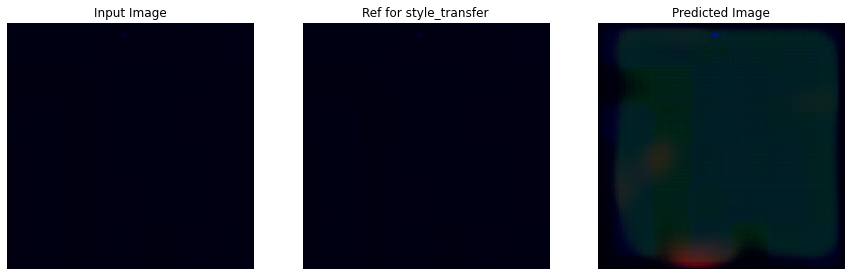

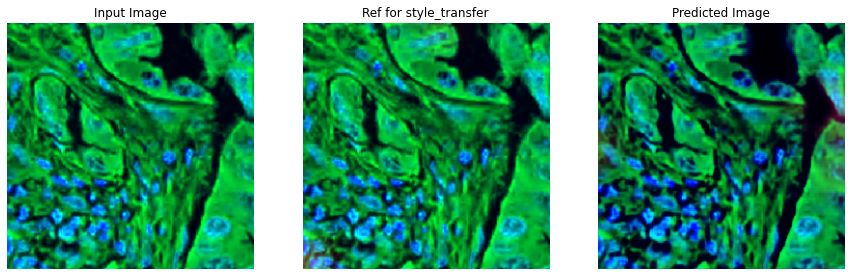

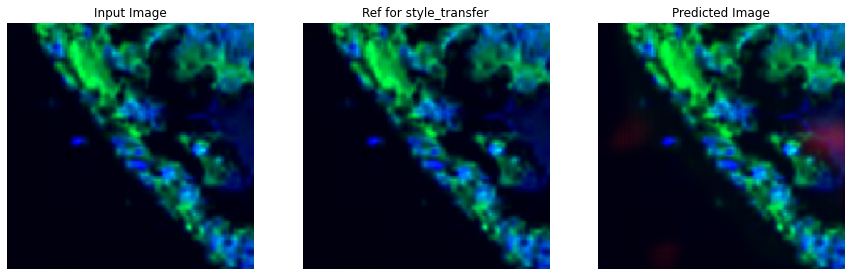

Epoch:  0
.

KeyboardInterrupt: 

In [46]:
fit(train_dataset, EPOCHS, valid_dataset)

## Restore the latest checkpoint and test

In [52]:
!ls {checkpoint_dir}

ckpt


## Testing trained model on datasets.

Tkinter is used to make this step interactive. It asks for the path of the input and output images

In [44]:
p_train=filedialog.askdirectory(title='path for train_results')
P_train_gt=os.path.join(p_train,"gt")
P_train_pred=os.path.join(p_train,"pred")
P_train_img=os.path.join(p_train,"img")
os.makedirs(P_train_img,exist_ok=True)
os.makedirs(P_train_gt,exist_ok=True)
os.makedirs(P_train_pred,exist_ok=True)
i=0
for x,y in train_dataset:
    for a,b in zip(x,y):
        v=generator(np.expand_dims(a,axis=0))
        img1=v[0]*0.5+0.5
        img2=b*0.5+0.5
        img3=a*0.5+0.5
        plt.imsave(P_train_pred+"/"+f"{i:06d}"+".png",img1.numpy())
        plt.imsave(P_train_gt+"/"+f"{i:06d}"+".png",img2.numpy())
        plt.imsave(P_train_img+"/"+f"{i:06d}"+".png",img3.numpy())
        print(i, end= " ")
        i=i+1

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

1862 1863 1864 1865 1866 1867 1868 1869 1870 1871 1872 1873 1874 1875 1876 1877 1878 1879 1880 1881 1882 1883 1884 1885 1886 1887 1888 1889 1890 1891 1892 1893 1894 1895 1896 1897 1898 1899 1900 1901 1902 1903 1904 1905 1906 1907 1908 1909 1910 1911 1912 1913 1914 1915 1916 1917 1918 1919 1920 1921 1922 1923 1924 1925 1926 1927 1928 1929 1930 1931 1932 1933 1934 1935 1936 1937 1938 1939 1940 1941 1942 1943 1944 1945 1946 1947 1948 1949 1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023 2024 2025 2026 2027 2028 2029 2030 2031 2032 2033 2034 2035 2036 2037 2038 2039 2040 2041 2042 2043 2044 2045 2046 2047 2048 2049 2050 2051 2052 2053 2054 2055 2056 2057 2058 2059 2060 2061 

3501 3502 3503 3504 3505 3506 3507 3508 3509 3510 3511 3512 3513 3514 3515 3516 3517 3518 3519 3520 3521 3522 3523 3524 3525 3526 3527 3528 3529 3530 3531 3532 3533 3534 3535 3536 3537 3538 3539 3540 3541 3542 3543 3544 3545 3546 3547 3548 3549 3550 3551 3552 3553 3554 3555 3556 3557 3558 3559 3560 3561 3562 3563 3564 3565 3566 3567 3568 3569 3570 3571 3572 3573 3574 3575 3576 3577 3578 3579 3580 3581 3582 3583 3584 3585 3586 3587 3588 3589 3590 3591 3592 3593 3594 3595 3596 3597 3598 3599 3600 3601 3602 3603 3604 3605 3606 3607 3608 3609 3610 3611 3612 3613 3614 3615 3616 3617 3618 3619 3620 3621 3622 3623 3624 3625 3626 3627 3628 3629 3630 3631 3632 3633 3634 3635 3636 3637 3638 3639 3640 3641 3642 3643 3644 3645 3646 3647 3648 3649 3650 3651 3652 3653 3654 3655 3656 3657 3658 3659 3660 3661 3662 3663 3664 3665 3666 3667 3668 3669 3670 3671 3672 3673 3674 3675 3676 3677 3678 3679 3680 3681 3682 3683 3684 3685 3686 3687 3688 3689 3690 3691 3692 3693 3694 3695 3696 3697 3698 3699 3700 

5143 5144 5145 5146 5147 5148 5149 5150 5151 5152 5153 5154 5155 5156 5157 5158 5159 5160 5161 5162 5163 5164 5165 5166 5167 5168 5169 5170 5171 5172 5173 5174 5175 5176 5177 5178 5179 5180 5181 5182 5183 5184 5185 5186 5187 5188 5189 5190 5191 5192 5193 5194 5195 5196 5197 5198 5199 5200 5201 5202 5203 5204 5205 5206 5207 5208 5209 5210 5211 5212 5213 5214 5215 5216 5217 5218 5219 5220 5221 5222 5223 5224 5225 5226 5227 5228 5229 5230 5231 5232 5233 5234 5235 5236 5237 5238 5239 5240 5241 5242 5243 5244 5245 5246 5247 5248 5249 5250 5251 5252 5253 5254 5255 5256 5257 5258 5259 5260 5261 5262 5263 5264 5265 5266 5267 5268 5269 5270 5271 5272 5273 5274 5275 5276 5277 5278 5279 5280 5281 5282 5283 5284 5285 5286 5287 5288 5289 5290 5291 5292 5293 5294 5295 5296 5297 5298 5299 5300 5301 5302 5303 5304 5305 5306 5307 5308 5309 5310 5311 5312 5313 5314 5315 5316 5317 5318 5319 5320 5321 5322 5323 5324 5325 5326 5327 5328 5329 5330 5331 5332 5333 5334 5335 5336 5337 5338 5339 5340 5341 5342 

6786 6787 6788 6789 6790 6791 6792 6793 6794 6795 6796 6797 6798 6799 6800 6801 6802 6803 6804 6805 6806 6807 6808 6809 6810 6811 6812 6813 6814 6815 6816 6817 6818 6819 6820 6821 6822 6823 6824 6825 6826 6827 6828 6829 6830 6831 6832 6833 6834 6835 6836 6837 6838 6839 6840 6841 6842 6843 6844 6845 6846 6847 6848 6849 6850 6851 6852 6853 6854 6855 6856 6857 6858 6859 6860 6861 6862 6863 6864 6865 6866 6867 6868 6869 6870 6871 6872 6873 6874 6875 6876 6877 6878 6879 6880 6881 6882 6883 6884 6885 6886 6887 6888 6889 6890 6891 6892 6893 6894 6895 6896 6897 6898 6899 6900 6901 6902 6903 6904 6905 6906 6907 6908 6909 6910 6911 6912 6913 6914 6915 6916 6917 6918 6919 6920 6921 6922 6923 6924 6925 6926 6927 6928 6929 6930 6931 6932 6933 6934 6935 6936 6937 6938 6939 6940 6941 6942 6943 6944 6945 6946 6947 6948 6949 6950 6951 6952 6953 6954 6955 6956 6957 6958 6959 6960 6961 6962 6963 6964 6965 6966 6967 6968 6969 6970 6971 6972 6973 6974 6975 6976 6977 6978 6979 6980 6981 6982 6983 6984 6985 

8426 8427 8428 8429 8430 8431 8432 8433 8434 8435 8436 8437 8438 8439 8440 8441 8442 8443 8444 8445 8446 8447 8448 8449 8450 8451 8452 8453 8454 8455 8456 8457 8458 8459 8460 8461 8462 8463 8464 8465 8466 8467 8468 8469 8470 8471 8472 8473 8474 8475 8476 8477 8478 8479 8480 8481 8482 8483 8484 8485 8486 8487 8488 8489 8490 8491 8492 8493 8494 8495 8496 8497 8498 8499 8500 8501 8502 8503 8504 8505 8506 8507 8508 8509 8510 8511 8512 8513 8514 8515 8516 8517 8518 8519 8520 8521 8522 8523 8524 8525 8526 8527 8528 8529 8530 8531 8532 8533 8534 8535 8536 8537 8538 8539 8540 8541 8542 8543 8544 8545 8546 8547 8548 8549 8550 8551 8552 8553 8554 8555 8556 8557 8558 8559 8560 8561 8562 8563 8564 8565 8566 8567 8568 8569 8570 8571 8572 8573 8574 8575 8576 8577 8578 8579 8580 8581 8582 8583 8584 8585 8586 8587 8588 8589 8590 8591 8592 8593 8594 8595 8596 8597 8598 8599 8600 8601 8602 8603 8604 8605 8606 8607 8608 8609 8610 8611 8612 8613 8614 8615 8616 8617 8618 8619 8620 8621 8622 8623 8624 8625 

In [45]:
p_test=filedialog.askdirectory(title='path for test_results')
P_test_gt=os.path.join(p_test,"gt")
P_test_pred=os.path.join(p_test,"pred")
P_test_img=os.path.join(p_test,"img")
os.makedirs(P_test_img,exist_ok=True)
os.makedirs(P_test_pred,exist_ok=True)
os.makedirs(P_test_gt,exist_ok=True)
i=0
for x,y in test_dataset:
    for a,b in zip(x,y):
        v=generator(np.expand_dims(a,axis=0))
        img1=v[0]*0.5+0.5
        img2=b*0.5+0.5
        img3=a*0.5+0.5
        plt.imsave(P_test_pred+"/"+f"{i:06d}"+".png",img1.numpy())
        plt.imsave(P_test_gt+"/"+f"{i:06d}"+".png",img2.numpy())
        plt.imsave(P_test_img+"/"+f"{i:06d}"+".png",img3.numpy())
        print(i, end= " ")
        i=i+1
for x,y in valid_dataset:
    for a,b in zip(x,y):
        v=generator(np.expand_dims(a,axis=0))
        img1=v[0]*0.5+0.5
        img2=b*0.5+0.5
        img3=a*0.5+0.5
        plt.imsave(P_test_pred+"/"+f"{i:06d}"+".png",img1.numpy())
        plt.imsave(P_test_gt+"/"+f"{i:06d}"+".png",img2.numpy())
        plt.imsave(P_test_img+"/"+f"{i:06d}"+".png",img3.numpy())
        print(i, end= " ")
        i=i+1

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

Onco-SG validation dataset

In [45]:
path_onco_sg=filedialog.askdirectory(title="onco_sg_images")
#date="13thOct"

files_onco_sg=[x for x in sorted(glob(path_onco_sg+"/*/*20x*.jpg"))]
st=set(([x.split("/")[len(x.split("/"))-2] for x in files_onco_sg]))
st=sorted(list(st))
len(st)

204

In [46]:
path_predict_onco_sg=filedialog.askdirectory(title="predict_onco_sg_images")

for x in st:
    os.makedirs(path_predict_onco_sg+"/"+x,exist_ok=True)
    y=sorted(glob(path_onco_sg+"/"+x+"/*20x*.jpg"))
    
    for z in y:
        fpath=path_predict_onco_sg+"/"+x+"/"+z.split("/")[-1]
        os.makedirs(fpath,exist_ok=True)
        spath=path_onco_sg+"/"+x+"/"+z.split("/")[-1]
        imgs_onco_sg=(sorted(glob(spath+"/*")))
        print(fpath)
        k=1
        for i in imgs_onco_sg:
            a=load_test(i,condtn=False)
            v=generator(np.expand_dims(a,axis=0))
            img=v[0]*0.5+0.5

            plt.imsave(fpath+"/"+f"{k:06d}"+".png",img.numpy())
            k=k+1
        

/home/saab/Desktop/onco_sg_trial/same/tiled/A006/A006, acinar, 20x.jpg
/home/saab/Desktop/onco_sg_trial/same/tiled/A008/A008, paillary, 20x.jpg
/home/saab/Desktop/onco_sg_trial/same/tiled/A012/A012, acinar, 20x.jpg
/home/saab/Desktop/onco_sg_trial/same/tiled/A015/A015, acinar, 20x.jpg
/home/saab/Desktop/onco_sg_trial/same/tiled/A016/A016, solid, 20x.jpg
/home/saab/Desktop/onco_sg_trial/same/tiled/A017/A017, acinar, 20x.jpg
/home/saab/Desktop/onco_sg_trial/same/tiled/A021/A021, acinar, 20x.jpg
/home/saab/Desktop/onco_sg_trial/same/tiled/A025/A025, invasive mucinous, 20x.jpg
/home/saab/Desktop/onco_sg_trial/same/tiled/A027/A027, acinar, 20x.jpg
/home/saab/Desktop/onco_sg_trial/same/tiled/A028/A028, acinar, 20x.jpg
/home/saab/Desktop/onco_sg_trial/same/tiled/A033/A033, solid, 20x.jpg
/home/saab/Desktop/onco_sg_trial/same/tiled/A037/A037, acinar, 20x.jpg
/home/saab/Desktop/onco_sg_trial/same/tiled/A062/A062, acinar, 20x.jpg
/home/saab/Desktop/onco_sg_trial/same/tiled/A063/A063, papillary, 

/home/saab/Desktop/onco_sg_trial/same/tiled/A217/A217, papillary, 20x.jpg
/home/saab/Desktop/onco_sg_trial/same/tiled/A218/A218, solid, 20x.jpg
/home/saab/Desktop/onco_sg_trial/same/tiled/A219/A219, lepidic predominant, 20x.jpg
/home/saab/Desktop/onco_sg_trial/same/tiled/A220/A220, distored acini, 20x.jpg
/home/saab/Desktop/onco_sg_trial/same/tiled/A221/A221, acinar with focal papillary, 20x.jpg
/home/saab/Desktop/onco_sg_trial/same/tiled/A221/A221, acinar, 20x.jpg
/home/saab/Desktop/onco_sg_trial/same/tiled/A222/A222, acinar, 20x.jpg
/home/saab/Desktop/onco_sg_trial/same/tiled/A228/A228, H&E, 20x (irregular nests with occasional lumen formation).jpg
/home/saab/Desktop/onco_sg_trial/same/tiled/A229/A229, H&E, 20x (non-small cell carcinoma forming solid nests).jpg
/home/saab/Desktop/onco_sg_trial/same/tiled/A230/A230, 20x (cribriform with luminal mucin).jpg
/home/saab/Desktop/onco_sg_trial/same/tiled/A230/A230, 20x, micropapillary (tufted).jpg
/home/saab/Desktop/onco_sg_trial/same/tiled

/home/saab/Desktop/onco_sg_trial/same/tiled/A521/A521, acinar, 20x.jpg
/home/saab/Desktop/onco_sg_trial/same/tiled/A522/A522, invasive mucinous, 20x.jpg
/home/saab/Desktop/onco_sg_trial/same/tiled/A524/A524, acinar, 20x.jpg
/home/saab/Desktop/onco_sg_trial/same/tiled/A530/A530, invasive mucinous, 20x.jpg
/home/saab/Desktop/onco_sg_trial/same/tiled/A532/A532, acinar, 20x.jpg
/home/saab/Desktop/onco_sg_trial/same/tiled/A534/A534, papillary, 20x.jpg
/home/saab/Desktop/onco_sg_trial/same/tiled/A537/A537, solid (sarcomatoid), 20x.jpg
/home/saab/Desktop/onco_sg_trial/same/tiled/A537/A537, solid, 20x.jpg
/home/saab/Desktop/onco_sg_trial/same/tiled/A538/A538, acinar, 20x.jpg


IHC Validation Dataset

In [43]:
path_val=filedialog.askdirectory(title="validation_images")
#date="13thOct"

files_val=[x for x in sorted(glob(path_val+"/*"))]
st=set(([x.split("/")[-1] for x in files_val]))
st=sorted(list(st))
st

['000.png',
 '001.png',
 '002.png',
 '003.png',
 '004.png',
 '005.png',
 '006.png',
 '007.png',
 '008.png',
 '009.png',
 '010.png',
 '011.png',
 '012.png',
 '013.png',
 '014.png',
 '015.png',
 '016.png',
 '017.png',
 '018.png',
 '019.png',
 '020.png',
 '021.png',
 '022.png',
 '023.png',
 '024.png',
 '025.png',
 '026.png',
 '027.png',
 '028.png',
 '029.png',
 '030.png',
 '031.png',
 '032.png',
 '033.png',
 '034.png',
 '035.png',
 '036.png',
 '037.png',
 '038.png',
 '039.png',
 '040.png',
 '041.png',
 '042.png',
 '043.png',
 '044.png',
 '045.png',
 '046.png',
 '047.png']

In [63]:
path_predict_val=filedialog.askdirectory(title="predict_validation_images")

for x in st:
    fpath=path_predict_val+"/"+x
    os.makedirs(fpath,exist_ok=True)
    y=sorted(glob(path_val+"/"+x+"/*"))
    #print(fpath)
    k=1
    print(len(y))
    for z in y:
        
        #print(z)
        
        a=load_valid(z,condtn=False)
        
    

        v=generator(np.expand_dims(a,axis=0))
        img=v[0]*0.5+0.5

        plt.imsave(fpath+"/"+f"{k:06d}"+".png",img.numpy())
           

        k=k+1    
        

420
(256, 240, 3)
0
16
(256, 240, 3)
0
16
(256, 240, 3)
0
16
(256, 240, 3)
0
16
(256, 240, 3)
0
16
(256, 240, 3)
0
16
(256, 240, 3)
0
16
(256, 240, 3)
0
16
(256, 240, 3)
0
16
(256, 240, 3)
0
16
(256, 240, 3)
0
16
(256, 240, 3)
0
16
(256, 240, 3)
0
16
(256, 240, 3)
0
16
(256, 240, 3)
0
16
(256, 240, 3)
0
16
(256, 240, 3)
0
16
(256, 240, 3)
0
16
(256, 240, 3)
0
16
(256, 240, 3)
0
16
(72, 256, 3)
184
0
(72, 256, 3)
184
0
(72, 256, 3)
184
0
(72, 256, 3)
184
0
(72, 256, 3)
184
0
(72, 256, 3)
184
0
(72, 256, 3)
184
0
(72, 256, 3)
184
0
(72, 256, 3)
184
0
(72, 256, 3)
184
0
(72, 256, 3)
184
0
(72, 256, 3)
184
0
(72, 256, 3)
184
0
(72, 256, 3)
184
0
(72, 256, 3)
184
0
(72, 256, 3)
184
0
(72, 256, 3)
184
0
(72, 256, 3)
184
0
(72, 256, 3)
184
0
(72, 240, 3)
184
16
441
(256, 105, 3)
0
151
(256, 105, 3)
0
151
(256, 105, 3)
0
151
(256, 105, 3)
0
151
(256, 105, 3)
0
151
(256, 105, 3)
0
151
(256, 105, 3)
0
151
(256, 105, 3)
0
151
(256, 105, 3)
0
151
(256, 105, 3)
0
151
(256, 105, 3)
0
151
(256, 105, 

(256, 72, 3)
0
184
(256, 72, 3)
0
184
(256, 72, 3)
0
184
(256, 72, 3)
0
184
(256, 72, 3)
0
184
(256, 72, 3)
0
184
(256, 72, 3)
0
184
(256, 72, 3)
0
184
(215, 256, 3)
41
0
(215, 256, 3)
41
0
(215, 256, 3)
41
0
(215, 256, 3)
41
0
(215, 256, 3)
41
0
(215, 256, 3)
41
0
(215, 256, 3)
41
0
(215, 256, 3)
41
0
(215, 256, 3)
41
0
(215, 256, 3)
41
0
(215, 256, 3)
41
0
(215, 256, 3)
41
0
(215, 256, 3)
41
0
(215, 256, 3)
41
0
(215, 256, 3)
41
0
(215, 256, 3)
41
0
(215, 256, 3)
41
0
(215, 256, 3)
41
0
(215, 256, 3)
41
0
(215, 256, 3)
41
0
(215, 72, 3)
41
184
441
(256, 138, 3)
0
118
(256, 138, 3)
0
118
(256, 138, 3)
0
118
(256, 138, 3)
0
118
(256, 138, 3)
0
118
(256, 138, 3)
0
118
(256, 138, 3)
0
118
(256, 138, 3)
0
118
(256, 138, 3)
0
118
(256, 138, 3)
0
118
(256, 138, 3)
0
118
(256, 138, 3)
0
118
(256, 138, 3)
0
118
(256, 138, 3)
0
118
(256, 138, 3)
0
118
(256, 138, 3)
0
118
(256, 138, 3)
0
118
(256, 138, 3)
0
118
(256, 138, 3)
0
118
(256, 138, 3)
0
118
(204, 256, 3)
52
0
(204, 256, 3)
52
0
(204, 

(105, 256, 3)
151
0
(105, 256, 3)
151
0
(105, 256, 3)
151
0
(105, 256, 3)
151
0
(105, 256, 3)
151
0
(105, 256, 3)
151
0
(105, 256, 3)
151
0
(105, 256, 3)
151
0
(105, 256, 3)
151
0
(105, 256, 3)
151
0
(105, 256, 3)
151
0
(105, 256, 3)
151
0
(105, 108, 3)
151
148
484
(256, 25, 3)
0
231
(256, 25, 3)
0
231
(256, 25, 3)
0
231
(256, 25, 3)
0
231
(256, 25, 3)
0
231
(256, 25, 3)
0
231
(256, 25, 3)
0
231
(256, 25, 3)
0
231
(256, 25, 3)
0
231
(256, 25, 3)
0
231
(256, 25, 3)
0
231
(256, 25, 3)
0
231
(256, 25, 3)
0
231
(256, 25, 3)
0
231
(256, 25, 3)
0
231
(256, 25, 3)
0
231
(256, 25, 3)
0
231
(256, 25, 3)
0
231
(256, 25, 3)
0
231
(256, 25, 3)
0
231
(256, 25, 3)
0
231
(80, 256, 3)
176
0
(80, 256, 3)
176
0
(80, 256, 3)
176
0
(80, 256, 3)
176
0
(80, 256, 3)
176
0
(80, 256, 3)
176
0
(80, 256, 3)
176
0
(80, 256, 3)
176
0
(80, 256, 3)
176
0
(80, 256, 3)
176
0
(80, 256, 3)
176
0
(80, 256, 3)
176
0
(80, 256, 3)
176
0
(80, 256, 3)
176
0
(80, 256, 3)
176
0
(80, 256, 3)
176
0
(80, 256, 3)
176
0
(80, 256, 3)

(36, 256, 3)
220
0
(36, 256, 3)
220
0
(36, 256, 3)
220
0
(36, 215, 3)
220
41
462
(256, 248, 3)
0
8
(256, 248, 3)
0
8
(256, 248, 3)
0
8
(256, 248, 3)
0
8
(256, 248, 3)
0
8
(256, 248, 3)
0
8
(256, 248, 3)
0
8
(256, 248, 3)
0
8
(256, 248, 3)
0
8
(256, 248, 3)
0
8
(256, 248, 3)
0
8
(256, 248, 3)
0
8
(256, 248, 3)
0
8
(256, 248, 3)
0
8
(256, 248, 3)
0
8
(256, 248, 3)
0
8
(256, 248, 3)
0
8
(256, 248, 3)
0
8
(256, 248, 3)
0
8
(256, 248, 3)
0
8
(256, 248, 3)
0
8
(135, 256, 3)
121
0
(135, 256, 3)
121
0
(135, 256, 3)
121
0
(135, 256, 3)
121
0
(135, 256, 3)
121
0
(135, 256, 3)
121
0
(135, 256, 3)
121
0
(135, 256, 3)
121
0
(135, 256, 3)
121
0
(135, 256, 3)
121
0
(135, 256, 3)
121
0
(135, 256, 3)
121
0
(135, 256, 3)
121
0
(135, 256, 3)
121
0
(135, 256, 3)
121
0
(135, 256, 3)
121
0
(135, 256, 3)
121
0
(135, 256, 3)
121
0
(135, 256, 3)
121
0
(135, 256, 3)
121
0
(135, 248, 3)
121
8
484
(256, 223, 3)
0
33
(256, 223, 3)
0
33
(256, 223, 3)
0
33
(256, 223, 3)
0
33
(256, 223, 3)
0
33
(256, 223, 3)
0
33
(25

(93, 256, 3)
163
0
(93, 77, 3)
163
179
462
(256, 50, 3)
0
206
(256, 50, 3)
0
206
(256, 50, 3)
0
206
(256, 50, 3)
0
206
(256, 50, 3)
0
206
(256, 50, 3)
0
206
(256, 50, 3)
0
206
(256, 50, 3)
0
206
(256, 50, 3)
0
206
(256, 50, 3)
0
206
(256, 50, 3)
0
206
(256, 50, 3)
0
206
(256, 50, 3)
0
206
(256, 50, 3)
0
206
(256, 50, 3)
0
206
(256, 50, 3)
0
206
(256, 50, 3)
0
206
(256, 50, 3)
0
206
(256, 50, 3)
0
206
(256, 50, 3)
0
206
(256, 50, 3)
0
206
(190, 256, 3)
66
0
(190, 256, 3)
66
0
(190, 256, 3)
66
0
(190, 256, 3)
66
0
(190, 256, 3)
66
0
(190, 256, 3)
66
0
(190, 256, 3)
66
0
(190, 256, 3)
66
0
(190, 256, 3)
66
0
(190, 256, 3)
66
0
(190, 256, 3)
66
0
(190, 256, 3)
66
0
(190, 256, 3)
66
0
(190, 256, 3)
66
0
(190, 256, 3)
66
0
(190, 256, 3)
66
0
(190, 256, 3)
66
0
(190, 256, 3)
66
0
(190, 256, 3)
66
0
(190, 256, 3)
66
0
(190, 50, 3)
66
206
484
(256, 80, 3)
0
176
(256, 80, 3)
0
176
(256, 80, 3)
0
176
(256, 80, 3)
0
176
(256, 80, 3)
0
176
(256, 80, 3)
0
176
(256, 80, 3)
0
176
(256, 80, 3)
0
176
(2

To get correct image paths before sorting

In [100]:
images = sorted(glob(os.path.join(path, "Images/*")))

In [101]:
lst_sort=[]
for x,y in zip(train_x,images):
    lst_sort.append([x.split("/")[-1],y.split("/")[-1]])

In [102]:
import pandas as pd
df_lst=pd.DataFrame(lst_sort)

In [56]:
df_lst.to_csv("/home/saab/Desktop/file_paths.csv")

In [103]:
lst_sort2=[]
for x in(test_x):
    lst_sort2.append([x.split("/")[-1]])
for x in(valid_x):
    lst_sort2.append([x.split("/")[-1]])
df_lst=pd.DataFrame(lst_sort2)
df_lst.to_csv("/home/saab/Desktop/file_paths_test.csv")